In [2]:
import cv2 as cv
import pydicom
import matplotlib.pyplot as plt
from matplotlib import path
import numpy as np
from scipy.interpolate import splprep, splev
import matlab.engine as mtlb
import matlab



In [3]:
def anchor_to_contour(orientation, endo_points, epi_points, nbr_points=100):
    '''
    From endo and epi anchor points, estimate full contour lines
    with cubic spline interpolation

    :param orientation: 'SA' (short axis slice) or 'LA' (long axis)
    :param endo_points: (N,2) array containing coordinates of endo anchor points
    :param epi_points: (M,2) array containing coordinates of endo anchor points
    :param nbr_points: number of points in the resulting interpolated contours
    :returns: tuple of interpolated endo and epi contours (nbr_points points in each)
    '''

    # If short axis, consider the contours to be closed
    if orientation == 'SA':
        epi_points = np.concatenate([epi_points, epi_points[0:1]], axis=0)
        endo_points = np.concatenate([endo_points, endo_points[0:1]], axis=0)
        closed = True
    elif orientation == 'LA':
        closed = False
    else:
        raise ValueError('ROI orientation axis should be either SA or LA')

    # Cubic spline interpolation, no smoothing
    endo_interp, _ = splprep([endo_points[:,0], endo_points[:,1]], s=0, per=closed)
    endo_sampling = np.arange(0, 1 + 1/nbr_points, 1/nbr_points)
    endo_contour = splev(endo_sampling, endo_interp)

    epi_interp, _ = splprep([epi_points[:,0], epi_points[:,1]], s=0, per=closed)
    epi_sampling = np.arange(0, 1 + 1/nbr_points, 1/nbr_points)
    epi_contour = splev(epi_sampling, epi_interp)

    return np.array(endo_contour), np.array(epi_contour)

In [4]:
def mask_from_contour(orientation, endo_contour, epi_contour, X, Y):

    if orientation == 'SA':

        p_endo = path.Path(endo_contour)
        p_epi = path.Path(epi_contour)

        mask_epi = p_epi.contains_points(list(zip(X.flatten(), Y.flatten()))).reshape(*X.shape)
        mask_endo = p_endo.contains_points(list(zip(X.flatten(), Y.flatten()))).reshape(*X.shape)

        mask_contours = np.zeros(mask_epi.shape).astype(bool)
        for contour in [endo_contour, epi_contour]:
            for point in contour:
                if (int(point[0]) == point[0]) and (int(point[1]) == point[1]):
                    mask_contours[point[1],point[0]] = 1
        return (mask_epi & ~mask_endo) | mask_contours

    elif orientation == 'LA':

        p = path.Path(np.concatenate([endo_contour, epi_contour]))
        return p.contains_points(list(zip(X.flatten(), Y.flatten()))).reshape(*X.shape)
    
    else:
        raise ValueError('ROI orientation axis should be either SA or LA')

In [5]:
image_file = "/home/hb20/PhD/data/dicom_dataset/00001_20160906/images/base_AveMag/im_0001_0012_0001.dcm"
label_file = "/home/hb20/PhD/data/dicom_dataset/00001_20160906/labels/base/lab_0001_0012_0001.dcm"

image = pydicom.read_file(image_file).pixel_array
label = pydicom.read_file(label_file).pixel_array

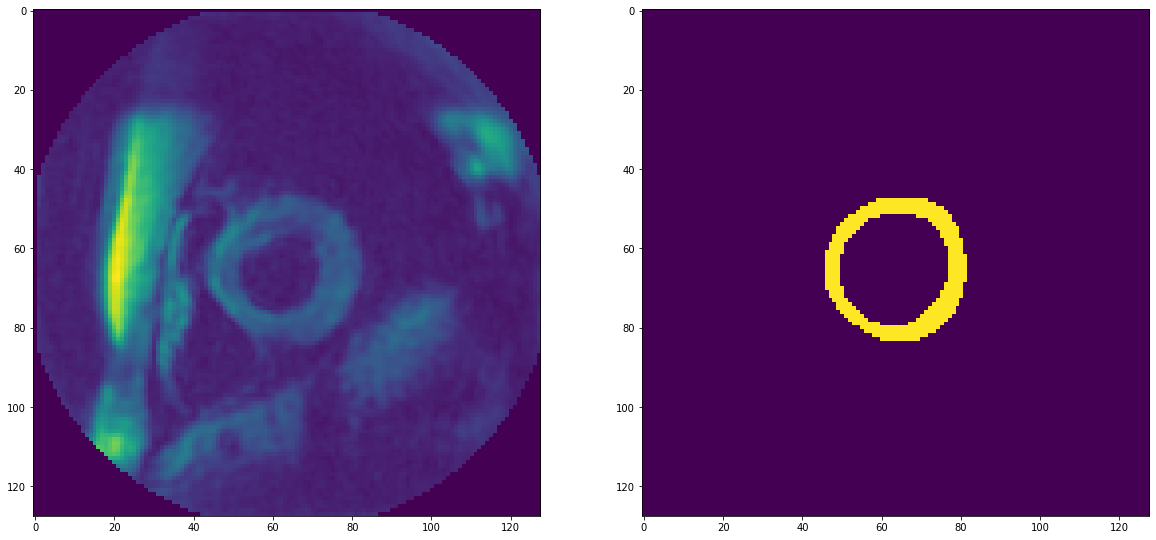

In [6]:
figure, axs = plt.subplots(1,2, figsize=(20,40))
axs[0].imshow(image)
axs[1].imshow(label)

In [7]:
contours, hierarchy = cv.findContours(1-label.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
contours_, hierarchy_ = cv.findContours(label.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

In [8]:
x, y = np.arange(0,128), np.arange(0,128)
X, Y = np.meshgrid(x, y)
mask = mask_from_contour('SA', contours[0][:,0,:], contours[1][:,0,:], X, Y)
mask_ = mask_from_contour('SA', contours_[0][:,0,:], contours_[1][:,0,:], X, Y)


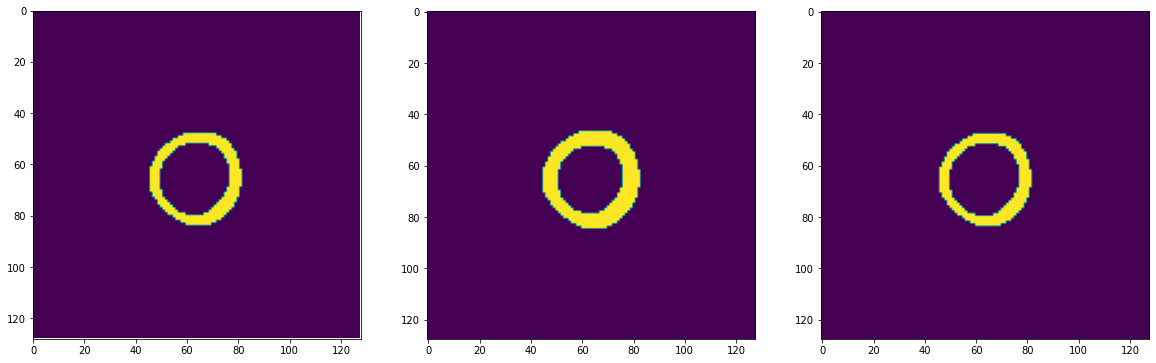

In [9]:
figure, axs = plt.subplots(1,3, figsize=(20,20))
axs[0].imshow(label)
#axs[0].scatter(contours[0][:,0,0], contours[0][:,0,1], s=8)
#axs[0].scatter(contours[1][:,0,0], contours[1][:,0,1], s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim(0,128)
axs[0].set_ylim(128,0)

axs[1].imshow(mask)
axs[2].imshow(mask_)


In [10]:
final_mask = 1-cv.drawContours(np.zeros((128,128)), contours, -1, (255),-1).astype(bool)
#eng.quit()
eng = mtlb.start_matlab()
res = eng.maskSA(matlab.double(X.T.flatten().tolist()), 
                 matlab.double(Y.T.flatten().tolist()), 
                 matlab.double(contours_[1][:,0,:].tolist()),
                 matlab.double(contours_[0][:,0,:].tolist()))


plt.figure(figsize=(6,6))
plt.imshow(np.asarray(res).reshape(128,128).T)

NameError: name 'eng' is not defined

In [47]:
(np.asarray(res).reshape(128,128).T == label).all()

True

In [24]:
contours_[1][:,0,:].shape

(101, 2)

In [11]:
a = contours_[0][::79//8+1,0,:]
b = contours_[1][::101//8+1,0,:]

(0.0, 128.0)

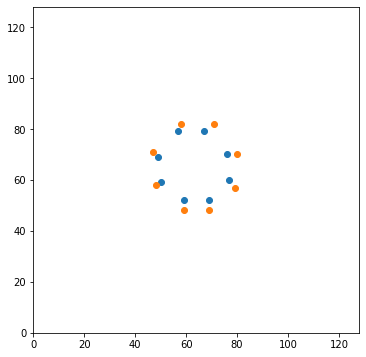

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(a[:,0], a[:,1])
plt.scatter(b[:,0], b[:,1])
plt.axis("scaled");
plt.xlim(0,128)
plt.ylim(0,128)

In [34]:
endo_contours, epi_contours = anchor_to_contour('SA', a, b, nbr_points=100)

(0.0, 128.0)

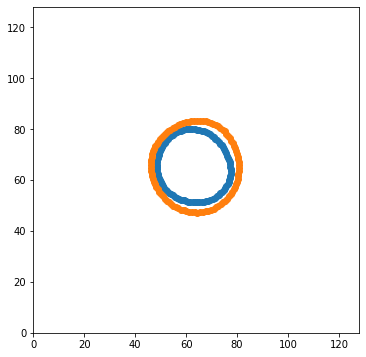

In [38]:
plt.figure(figsize=(6,6))
plt.scatter(endo_contours[0], endo_contours[1])
plt.scatter(epi_contours[0], epi_contours[1])
plt.axis("scaled");
plt.xlim(0,128)
plt.ylim(0,128)

In [37]:
endo_contours.shape

(2, 101)

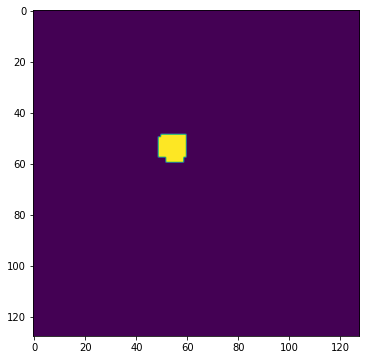

In [49]:
eng.quit()
eng = mtlb.start_matlab()
res = eng.maskSA(matlab.double(X.T.flatten().tolist()), 
                 matlab.double(Y.T.flatten().tolist()), 
                 matlab.double(endo_contours.tolist()),
                 matlab.double(epi_contours.tolist()))


plt.figure(figsize=(6,6))
plt.imshow(np.asarray(res).reshape(128,128).T)

In [52]:
mask__ = mask_from_contour('SA', endo_contours.T-0.5, epi_contours.T+0.5, X, Y)

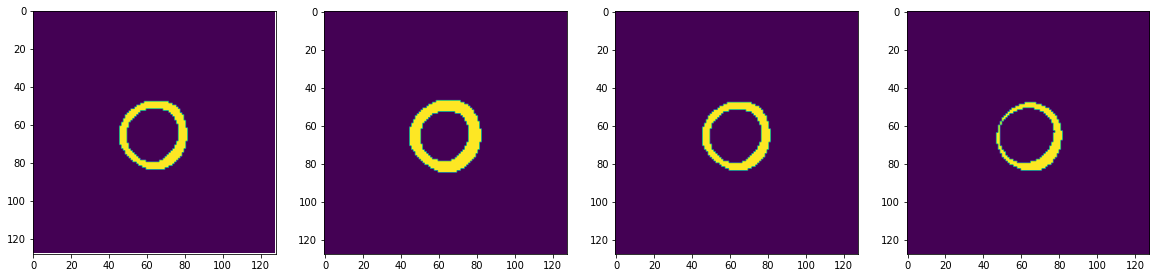

In [53]:
figure, axs = plt.subplots(1,4, figsize=(20,20))
axs[0].imshow(label)
#axs[0].scatter(contours[0][:,0,0], contours[0][:,0,1], s=8)
#axs[0].scatter(contours[1][:,0,0], contours[1][:,0,1], s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim(0,128)
axs[0].set_ylim(128,0)

axs[1].imshow(mask)
axs[2].imshow(mask_)
axs[3].imshow(mask__)